# Employ new PPs (new $r_c$) for computing Pressure vs. $V/V_0$

## import some modules

In [1]:
from dftpy.ions import Ions
from dftpy.field import DirectField
from dftpy.grid import DirectGrid
from dftpy.functional import LocalPseudo, Functional, TotalFunctional
from dftpy.formats import io
from dftpy.math_utils import ecut2nr
from dftpy.time_data import TimeData
from dftpy.optimization import Optimization
from dftpy.mpi import sprint

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from ase.build import bulk

In [3]:
from dftpy.constants import ENERGY_CONV, STRESS_CONV, LEN_CONV

### Build structure

In [4]:
atoms = bulk(name='Al', crystalstructure='fcc', a=4.05, cubic=True)

### Methods to optimize density (ground state) and compute stress

In [6]:
def get_stress_TFvW(grid, ions, PP_list):
    ```
    Method to compute stress with Thomas-Fermi-von-
    ```
    from dftpy.functional.kedf import ThomasFermiStress, vonWeizsackerStress
    ##  build local pseudo, and generate guess density
    PSEUDO = LocalPseudo(grid = grid, ions=ions, PP_list=PP_list)
    rho_ini = DirectField(grid=grid)
    rho_ini[:] = ions.get_ncharges()/ions.cell.volume
    ## instance KEDF, XC and HARTREE functionals
    KE = Functional(type='KEDF',name='TFvW')
    XC = Functional(type='XC',name='LDA')
    HARTREE = Functional(type='HARTREE')
    
    ## instance DFTpy evaluator
    evaluator = TotalFunctional(KE=KE, XC=XC, HARTREE=HARTREE, PSEUDO=PSEUDO)
    
    ## instance and execute DFTpy density optimizer
    optimization_options = {'econv' : 1e-9*ions.nat}
    opt = Optimization(EnergyEvaluator=evaluator, optimization_options = optimization_options, optimization_method = 'CG')
    rho = opt.optimize_rho(guess_rho=rho_ini)
    print('STRESS: ',ThomasFermiStress(rho)[0,0],vonWeizsackerStress(rho)[0,0])
    return (evaluator.compute(rho).energy, evaluator.get_stress(rho)[0,0])
    
# grid, kedf, ions, PP_linst
def get_stress_WT(grid, ions, PP_list):
    from dftpy.functional.kedf import WTStress, ThomasFermiStress, vonWeizsackerStress
    ##  build local pseudo, and generate guess density
    PSEUDO = LocalPseudo(grid = grid, ions=ions, PP_list=PP_list)
    rho_ini = DirectField(grid=grid)
    rho_ini[:] = ions.get_ncharges()/ions.cell.volume
    ## instance KEDF, XC and HARTREE functionals
    KE = Functional(type='KEDF',name='WT')
    XC = Functional(type='XC',name='LDA')
    HARTREE = Functional(type='HARTREE')
    
    ## instance DFTpy evaluator
    evaluator = TotalFunctional(KE=KE, XC=XC, HARTREE=HARTREE, PSEUDO=PSEUDO)
    
    ## instance and execute DFTpy density optimizer
    optimization_options = {'econv' : 1e-8*ions.nat}
    opt = Optimization(EnergyEvaluator=evaluator, optimization_options = optimization_options, optimization_method = 'CG')
    rho = opt.optimize_rho(guess_rho=rho_ini)
    return (evaluator.compute(rho).energy, evaluator.get_stress(rho)[0,0])

## Load the pseudopotential files

In [30]:
PP_list_13 = {'Al': './Al_1.3.psp8'}
PP_list_14 = {'Al': './Al_1.4.psp8'}
PP_list_20 = {'Al': './Al_2.0.psp8'}
PP_list = {'Al': './Al_OEPP_PZ.UPF'}

## Compute the stresses for varying volume

In [31]:
Stress_OEPP = []
Stress_cOEPP_13 = []
Stress_cOEPP_14 = []
Stress_cOEPP_20 = []
v_exp = [1.0,0.634,0.601,0.568,0.535,0.502,0.469,0.436,0.403,0.370,0.337,0.304]
Stress_EXP = [0.0,0.086,0.108,0.135,0.168,0.211,0.265,0.338,0.435,0.568,0.754,1.018]
v_calc = [1.0,0.9,0.8,0.7, 0.634,0.502,0.403,0.304]
for v in v_calc:

    from ase.build import bulk
    atoms = bulk(name='Al', crystalstructure='fcc', a=np.cbrt(v)*4.05, cubic=True)
    ions = Ions.from_ase(atoms)
    
    nr = ecut2nr(ecut=200, lattice=ions.cell)
    grid = DirectGrid(lattice=ions.cell, nr=nr)
    Stress_OEPP.append(get_stress_WT(grid,ions,PP_list))
    Stress_cOEPP_13.append(get_stress_WT(grid,ions,PP_list_13))
    Stress_cOEPP_14.append(get_stress_WT(grid,ions,PP_list_14))
    Stress_cOEPP_20.append(get_stress_WT(grid,ions,PP_list_20))



setting key: Al -> ./Al_1.3.psp8
Step    Energy(a.u.)            dE              dP              Nd      Nls     Time(s)         
0       -1.973623350392E+01     -1.973623E+01   1.671442E+00    1       1       4.051375E-02    
1       -2.083199678242E+01     -1.095763E+00   4.414307E+00    1       3       1.106598E-01    
2       -2.099123478805E+01     -1.592380E-01   4.359062E+00    1       2       1.580617E-01    
3       -2.104099102453E+01     -4.975624E-02   3.044949E+00    1       2       2.029328E-01    
4       -2.107159215556E+01     -3.060113E-02   2.660664E+00    1       3       2.718937E-01    
5       -2.109502180270E+01     -2.342965E-02   2.347584E+00    1       3       3.399229E-01    
6       -2.110839812463E+01     -1.337632E-02   1.246217E+00    1       3       4.087067E-01    
7       -2.111922899602E+01     -1.083087E-02   1.088562E+00    1       3       4.762638E-01    
8       -2.113223593830E+01     -1.300694E-02   2.208141E+00    1       3       5.460558E-01  

In [33]:
Stress_OEPP = np.asarray(Stress_OEPP)
Stress_cOEPP_13 = np.asarray(Stress_cOEPP_13)
Stress_cOEPP_14 = np.asarray(Stress_cOEPP_14)
Stress_cOEPP_20 = np.asarray(Stress_cOEPP_20)

In [34]:
au_to_gpa = STRESS_CONV['Ha/Bohr3']['GPa']
au_to_tpa = au_to_gpa/1000
au_to_tpa

29.42101527108086

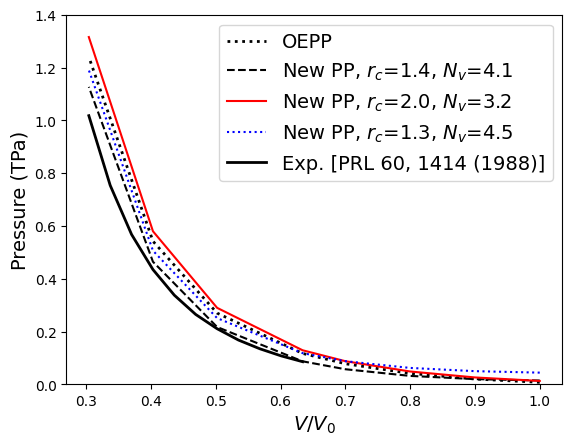

In [36]:
plt.plot(v_calc,-(Stress_OEPP[:,1])*au_to_tpa,label="OEPP",color='k',ls=':',lw=2)
plt.plot(v_calc,-(Stress_cOEPP_14[:,1])*au_to_tpa,label="New PP, $r_c$=1.4, $N_v$=4.1",color='k',ls='--')
plt.plot(v_calc,-(Stress_cOEPP_20[:,1])*au_to_tpa,label="New PP, $r_c$=2.0, $N_v$=3.2",color='r',ls='-')
plt.plot(v_calc,-(Stress_cOEPP_13[:,1])*au_to_tpa,label="New PP, $r_c$=1.3, $N_v$=4.5",color='b',ls=':')
plt.plot(v_exp[1:],Stress_EXP[1:],label="Exp. [PRL 60, 1414 (1988)]",color='k',ls='-',lw=2)
plt.xlabel(r"$V/V_0$",fontsize=14)
plt.ylabel(r"Pressure (TPa)",fontsize=14)
#plt.xlim(0.3,0.65)
plt.ylim(0,1.4)
plt.legend(fontsize=14)
plt.savefig("PP_good.pdf")